In [1]:
import os
import platform
import random
import shutil
import sys

import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn.metrics
import tensorflow as tf
from tensorflow.python.saved_model import tag_constants
from tqdm import tqdm_notebook as tqdm
import keras 
%matplotlib inline
random.seed(0)

Using TensorFlow backend.


In [2]:
# read in data compiled from Hui et. al 
# binary: has two tabs for positive (i.e. yes off-target), and one for negative 
data_dir = './data/'
# diff sheets, so need to read in 
file_name = data_dir + 'binary_data_hui.xlsx'
df = pd.read_excel(file_name, sheet_name=None)

In [3]:
# combine into single dataset, where 'score' labels whether the example is positive or not
# also stores the on-target and off-target sites
ontarget_seqs = np.concatenate((df['low throughput']['on-target site'], df['high throughput']['on-target site'], df['negative']['on-target site']),axis = None)
offtarget_site = np.concatenate((df['low throughput']['off-target site'], df['high throughput']['off-target site'], df['negative']['no editing site']),axis = None)
# fill the scores (binary) column w/ ones if low/high or zero if no editing (based on sizes of arrays)
scores = np.concatenate((np.ones(np.shape(df['low throughput']['on-target site'])), np.ones(np.shape(df['high throughput']['on-target site'])), np.zeros(np.shape(df['negative']['on-target site']))), axis = None)
# combine to a new dataframe
df = pd.DataFrame({'On-Target Site': ontarget_seqs, 'Off-Target Site': offtarget_site, 'Score': scores})
df.to_csv('processed_binary_data.csv')


In [4]:
df.head(5)

,On-Target Site,Off-Target Site,Score
0,AAATGAGAAGAAGAGGCACAGGG,AAAAGAGAAGCTGAGGCACAGGG,1.0
1,AAATGAGAAGAAGAGGCACAGGG,AAACGAGAAGAAGAGGCATAGGG,1.0
2,AAATGAGAAGAAGAGGCACAGGG,AAACGAGAAGAAGCTGCACATGG,1.0
3,AAATGAGAAGAAGAGGCACAGGG,AAAGGAGAAGGAGAGGCAGATGG,1.0
4,AAATGAGAAGAAGAGGCACAGGG,AAATCATATGAAGAGGCACAAGG,1.0


In [5]:
# get number of sequences
num_seqs = len(df['On-Target Site'])
print('num data points: ', num_seqs)

num data points:  409002


In [6]:
# check lengths -- confirm all are same when comparing across datasets
seq_len = len(df['On-Target Site'][0])
print('Guide length: ', seq_len) # NOTE: WT seq is the reverse complement of guide 
print('Off-target:', len(df['Off-Target Site'][0]))

Guide length:  23
Off-target: 23


In [7]:
# look at class balance ...
num_positive = int(sum(df['Score']))
print('num positive:', num_positive)
print('num negative (no editing):', num_seqs - num_positive)

num positive: 742
num negative (no editing): 408260


In [55]:
# custom encoding -- new alphabet
nts = 'ATCG'
# look for any characters not in usual nts
for idx,(guide,ot) in enumerate(zip(df['On-Target Site'], df['Off-Target Site'])):
    if not all(c in nts for c in guide) or not all(c in nts for c in ot): 
        print(guide, ot)
    if '-' in guide: print(guide)
    if '-' in ot: print(ot)
# consider '-' as N (any nt)

In [8]:
# new encoding will map to a new alphabet based on the correspondance of guide and off-target
new_alph_map = {'AA': 'K', 'AT': 'R', 'AC': 'Z', 'AG': 'Y', 'TT': 'L', 'TC': 'M', 'TG':'J', 
                'CC': 'P', 'CG':'H', 'GG': 'E'}
encoded_seqs = [] 
for idx,(guide,ot) in enumerate(zip(df['On-Target Site'], df['Off-Target Site'])):
    new_seq = ''
    for g,o in zip(guide,ot):
        # if '-', imagine it's a match -- may need to CHANGE
        if o == '-': 
            new_seq += new_alph_map[g+g]
            continue
        # combine guide and ot nt to get new letter
        code = g+o
        if code in new_alph_map: new_seq += new_alph_map[code]
        else: new_seq += new_alph_map[o+g] # reverse code
    encoded_seqs.append(new_seq)

In [9]:
df['Encoded Seqs'] = encoded_seqs
df.head(5)
df.to_csv('processed_binary_data.csv')

In [10]:
new_alph = list(new_alph_map.values())


# one-hot encode
def _get_one_hot_encoding(seq):
  """Generate one-hot encoding for a single nucleotide sequence."""
  return pd.get_dummies(
      list(seq) + new_alph)[:-len(new_alph)].as_matrix().transpose()

onehot_seqs = np.stack(
    [_get_one_hot_encoding(s) for s in encoded_seqs]).astype(np.float32)
onehot_seqs_flat = np.reshape(onehot_seqs, (-1, len(new_alph) * seq_len))

/Users/kcollins/anaconda/envs/deeptoehold/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [19]:
# pca - code: https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60 
from sklearn.decomposition import PCA

X = onehot_seqs_flat

pca = PCA(n_components=3)

principalComponents = pca.fit_transform(X)

principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PC 1', 'PC 2', 'PC 3'])

In [20]:
pca.explained_variance_

array([1.12510513, 0.95324981, 0.84486017])

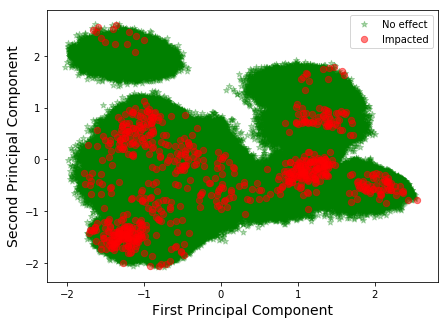

In [21]:
# from: https://towardsdatascience.com/dive-into-pca-principal-component-analysis-with-python-43ded13ead21
# trying to better see pairs where off-target is affected
cdict={0:'green',1:'red'}

labl={0:'No effect',1:'Impacted'}

marker={0:'*',1:'o'}

alpha={0:.3, 1:.5}

fig,ax=plt.subplots(figsize=(7,5))
fig.patch.set_facecolor('white')

ot_score = df['Score']

pc1 = np.array(principalDf['PC 1'])
pc2 = np.array(principalDf['PC 2'])
for l in np.unique(ot_score):
    ix=np.where(ot_score==l)
    ax.scatter(pc1[ix],pc2[ix],c=cdict[l],s=40,label=labl[l],marker=marker[l],alpha=alpha[l])    
    
# for loop ends

plt.xlabel("First Principal Component",fontsize=14)
plt.ylabel("Second Principal Component",fontsize=14)
plt.legend()
plt.show()

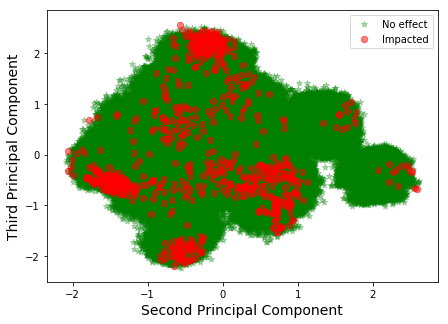

In [22]:
# from: https://towardsdatascience.com/dive-into-pca-principal-component-analysis-with-python-43ded13ead21
# trying to better see pairs where off-target is affected
cdict={0:'green',1:'red'}

labl={0:'No effect',1:'Impacted'}

marker={0:'*',1:'o'}

alpha={0:.3, 1:.5}

fig,ax=plt.subplots(figsize=(7,5))
fig.patch.set_facecolor('white')

ot_score = df['Score']

pc1 = np.array(principalDf['PC 2'])
pc2 = np.array(principalDf['PC 3'])
for l in np.unique(ot_score):
    ix=np.where(ot_score==l)
    ax.scatter(pc1[ix],pc2[ix],c=cdict[l],s=40,label=labl[l],marker=marker[l],alpha=alpha[l])    
    
# for loop ends

plt.xlabel("Second Principal Component",fontsize=14)
plt.ylabel("Third Principal Component",fontsize=14)
plt.legend()
plt.show()

In [16]:
# now try tSNE 
# color again by whether impacted or not 
from sklearn.manifold import TSNE

tsne = TSNE(2, random_state = 0)
X_tsne = tsne.fit_transform(X)

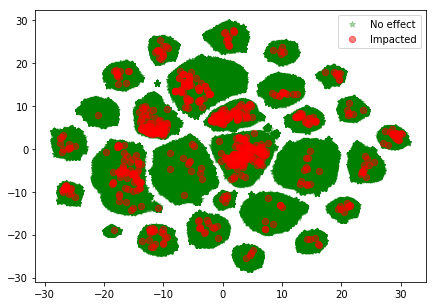

In [17]:
# from: https://towardsdatascience.com/dive-into-pca-principal-component-analysis-with-python-43ded13ead21
# trying to better see pairs where off-target is affected
cdict={0:'green',1:'red'}

labl={0:'No effect',1:'Impacted'}

marker={0:'*',1:'o'}

alpha={0:.3, 1:.5}

fig,ax=plt.subplots(figsize=(7,5))
fig.patch.set_facecolor('white')

tsne_dim1 = np.array(X_tsne[:,0])
tsne_dim2 = np.array(X_tsne[:,1])
for l in np.unique(ot_score):
    ix=np.where(ot_score==l)
    ax.scatter(tsne_dim1[ix],tsne_dim2[ix],c=cdict[l],s=40,label=labl[l],marker=marker[l],alpha=alpha[l])    
    
#plt.xlabel("New Dim 1",fontsize=14)
#plt.ylabel("Second Principal Component",fontsize=14)
plt.legend()
plt.show()

{'K': 2426,
 'R': 422,
 'E': 5620,
 'Z': 435,
 'P': 3865,
 'M': 623,
 'J': 410,
 'Y': 925,
 'H': 432,
 'L': 1908}

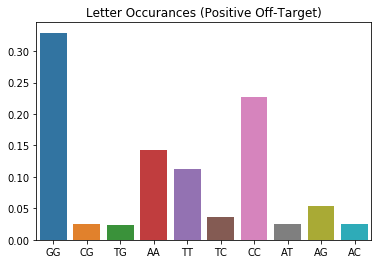

<Figure size 432x288 with 0 Axes>

In [25]:
reverse_map = {v:k for k,v in new_alph_map.items()}

def letter_occurance_plot(data_frame, true_score, title = 'Letter Occurances'): 
    letter_occurances = {}
    for s, score in zip(data_frame['Encoded Seqs'], data_frame['Score']): 
        if score == true_score: 
            for c in s: 
                if c in letter_occurances: letter_occurances[c] += 1
                else: letter_occurances[c] = 1
    tot = sum(letter_occurances.values())
    # need to ensure ordering is correct (dictionaries unordered)
    #letters = []
    vals = [] 
    letters = sorted(list(letter_occurances.keys()))
    for k in letters:
        vals.append(letter_occurances[k]/tot)
    sns.barplot([reverse_map[letter] for letter in letters], vals)
    plt.title(title)
    plt.figure();
    return letter_occurances

title = 'Letter Occurances'
letter_occurance_plot(df, 1, title + ' (Positive Off-Target)')


{'K': 1441250,
 'R': 444260,
 'Y': 557900,
 'E': 2945946,
 'P': 1246619,
 'H': 437325,
 'J': 496473,
 'Z': 378646,
 'M': 349169,
 'L': 1092392}

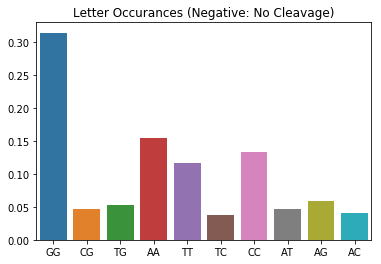

<Figure size 432x288 with 0 Axes>

In [26]:
letter_occurance_plot(df,0, title + ' (Negative: No Cleavage)')
